# STEP 1 : 시계열 데이터 준비

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')

### Time Series 생성

- ##### 005930.KS는 삼성전자 데이터

In [2]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

In [3]:
ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

# STEP 2 : 각종 전처리 수행

### 결측치 처리

In [4]:
ts = ts.interpolate(method='time')

In [5]:
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

##### Time Series에서 결측치가 있는 부분만 Series로 출력

### 로그 변환

In [6]:
ts_log = np.log(ts)

# STEP 3 : 시계열 안정성 분석

### 정성적 그래프 분석

In [7]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

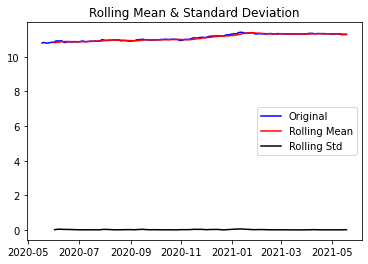

In [8]:
plot_rolling_statistics(ts_log, window=12)

- ##### 그래프만 보면 시계열이 안정성이 있어보인다.

### 정량적 Augmented Dicky-Fuller Test

In [9]:
from statsmodels.tsa.stattools import adfuller

In [10]:
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [11]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


- #### 1) Test Statistic의 값이 Critical Value보다 낮아야 하는데 크다.
  
- #### 2) p-value가 유의수준 0.01보다 크다.

- #### 결론) 시계열은 안정적이지 않다.

### 시계열 분해 (Time Series Decomposition)

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

In [13]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

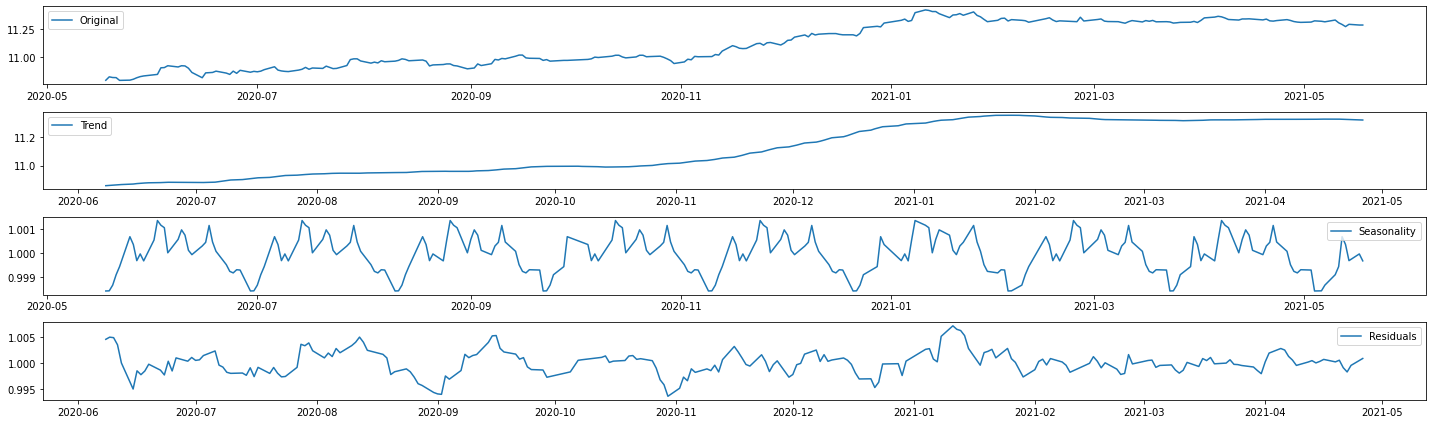

In [14]:
plt.figure(figsize=(20,6))
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

- ##### Trend와 Seasonality가 잘 제거되어서 Residual에서 추세나 계절성이 보이지 않으므로 안정성이 있다고 볼 수 있을 것 같다.

### Residual 안정성 확인

In [15]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


In [16]:
print('Test Statistic', format(-6.187586e+00, '.11f'))
print('p-value', format(6.234854e-08, '.11f'))
print('Critical Value (1%)', format(-3.461879e+00, '.11f'))

Test Statistic -6.18758600000
p-value 0.00000006235
Critical Value (1%) -3.46187900000


- #### 1) Test Statistic의 값이 Critical Value보다 낮다.
  
- #### 2) p-value가 유의수준 0.01보다 작다.

- #### 결론) 시계열은 안정적이다.

# STEP 4 : 학습, 테스트 데이터셋 생성

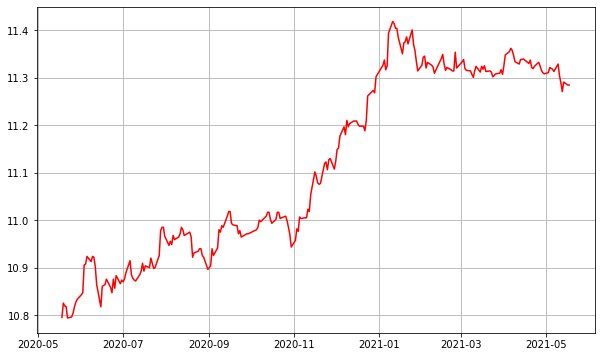

In [17]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')
plt.show()

##### train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택

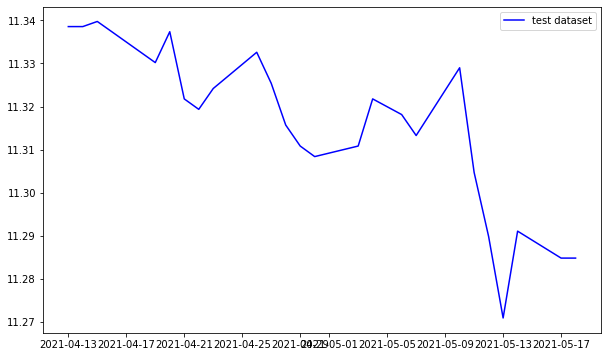

In [18]:
plt.figure(figsize=(10,6))
plt.plot(test_data, c='b', label='test dataset')
plt.legend()
plt.show()

# STEP 5 : 적정 ARIMA 모수 찾기

### ACF, PACF를 그려서 p,q 구하기

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

### ACF : Autocorrelation

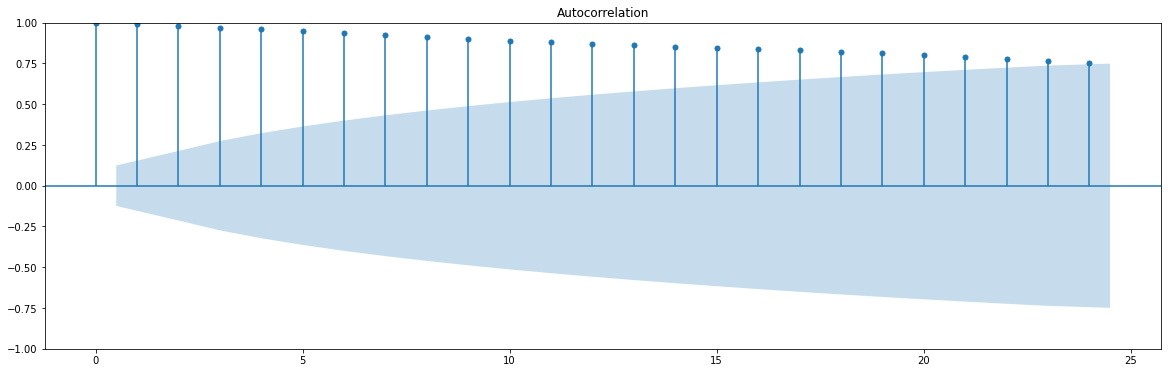

In [20]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 6
plot_acf(ts_log)
plt.show()

- ##### 모든 값이 유의미하다고 한다. q는 없다.

### PACF : Partial Autocorrelation

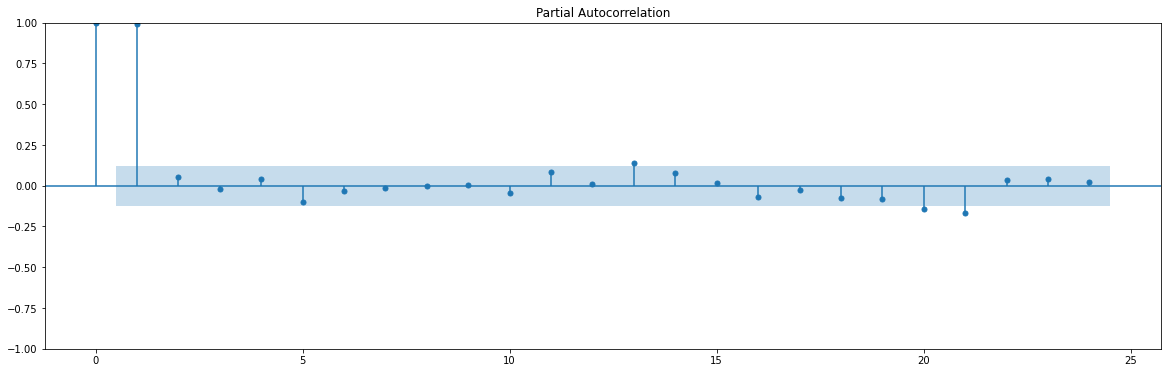

In [21]:
rcParams['figure.figsize'] = 20, 6
plot_pacf(ts_log)
plt.show()

- ##### Lag 1, 13, 20, 21을 p의 후보로 놓고 실행해보기로 했다.

### 차분 안정성 확인 -> d 구하기

##### 1차 차분 구하기

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


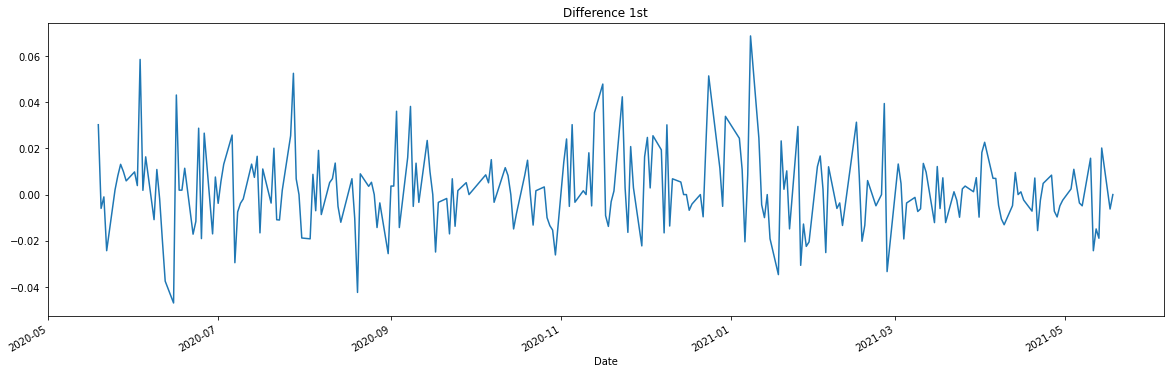

In [22]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')
augmented_dickey_fuller_test(diff_1)
plt.show()

In [23]:
print('Test Statistic', format(-1.553699e+01, '.11f'))
print('p-value', format(2.183738e-28, '.11f'))
print('Critical Value (1%)', format(-3.456996e+00, '.11f'))

Test Statistic -15.53699000000
p-value 0.00000000000
Critical Value (1%) -3.45699600000


- #### 1) Test Statistic의 값이 Critical Value보다 낮다.
  
- #### 2) p-value가 유의수준 0.01보다 작다.

- #### 결론) 시계열은 안정적이다. 2차 차분은 필요하지 않을 것 같다. d = 1

##### 혹시 필요한 경우 2차 차분 구하기

In [24]:
# diff_2 = diff_1.diff(periods=1).iloc[1:]
# diff_2.plot(title='Difference 2nd')
# augmented_dickey_fuller_test(diff_2)
# plt.show()

# STEP 6 : ARIMA 모델 훈련과 테스트

### ARIMA 모델 빌드와 훈련

- ##### (p, d, q)의 값으로 (1, 1, 0)을 넣으려고 하지만 autoARIMA의 결과값이 궁금해서 구해봤다.

In [25]:
import pmdarima as pm
model = pm.AutoARIMA(seasonal = True, suppress_warnings = True, trace = True, max_D = 12)
res = model.fit(ts_log)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1305.690, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1313.151, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1311.207, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1311.208, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1311.916, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1309.213, Time=0.17 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.099 seconds


- ##### AutoARIMA는 (0, 1, 0)이 최선이라고 한다. 우선은 ACF, PACF, 차분을 통해서 얻은 값으로 ARIMA를 적합시켰다.

In [26]:
from statsmodels.tsa.arima.model import ARIMA

In [27]:
model = ARIMA(train_data, order=(13, 1, 0))  
fitted_m = model.fit() 
print(fitted_m.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                ARIMA(13, 1, 0)   Log Likelihood                 587.273
Date:                Thu, 05 Jan 2023   AIC                          -1146.546
Time:                        11:15:24   BIC                          -1098.783
Sample:                             0   HQIC                         -1127.267
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0431      0.066      0.649      0.516      -0.087       0.173
ar.L2         -0.0162      0.080     -0.204      0.839      -0.172       0.140
ar.L3         -0.0405      0.075     -0.541      0.5

### 모델 테스트 및 플로팅

In [28]:
fc = fitted_m.forecast(len(test_data), alpha=0.05)
fc = np.array(fc)

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


##### Forecast : 결과가 fc에 담김

##### alpha=0.05 : 95% conf

In [29]:
fc_series = pd.Series(fc, index=test_data.index)

##### 예측 결과를 pandas series로 만듦

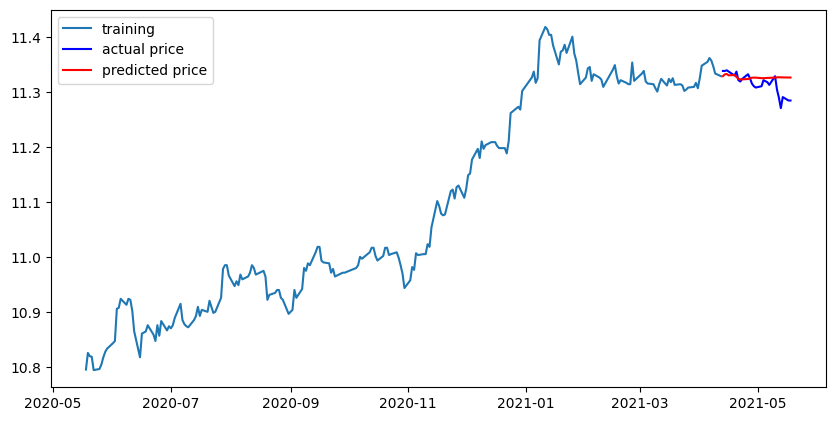

In [30]:
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

### 최종 예측 모델 정확도 측정(MAPE)

In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  3011780.477627641
MAE:  1233.786917262004
RMSE:  1735.4482065528896
MAPE: 1.53%


(0, 1, 0)    MAPE: 1.74%


(1, 1, 0)    MAPE: 1.74%


(13, 1, 0)   MAPE: 1.53%


(20, 1, 0)   MAPE: 1.70%


(21, 1, 0)   MAPE: 1.77%

- ##### (13, 1, 0) MAPE: 1.53%이 가장 정확한 예측도를 보였다.

# STEP 7 : 다른 주식 종목 예측해 보기

## 1. 구글 - Alphabet Inc. (GOOG)

In [32]:
dataset_filepath = os.getenv('HOME') + '/aiffel/7주차/GOOG.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

In [33]:
ts.head()

Date
2022-01-04    144.416504
2022-01-05    137.653503
2022-01-06    137.550995
2022-01-07    137.004501
2022-01-10    138.574005
Name: Close, dtype: float64

In [34]:
ts = ts.interpolate(method='time')

In [35]:
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [36]:
ts_log = np.log(ts)

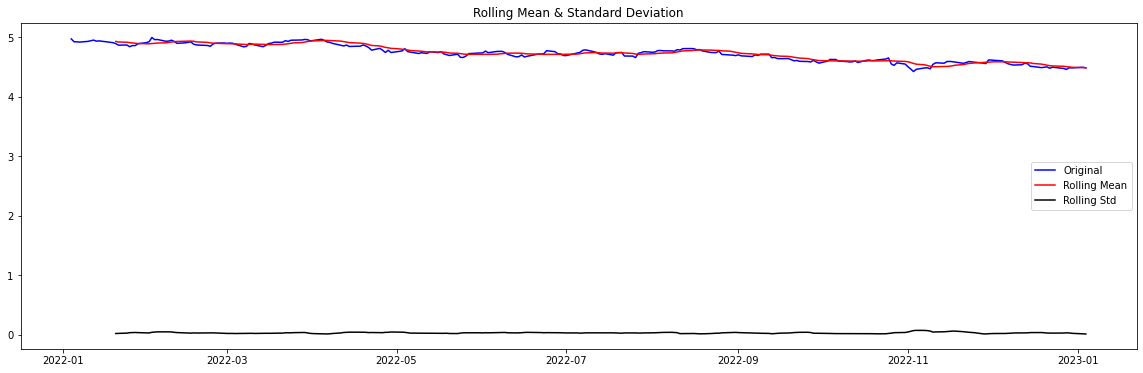

In [37]:
plot_rolling_statistics(ts_log, window=12)

- ##### 그래프만 보면 시계열이 안정성이 있어보인다.

In [38]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.338251
p-value                          0.611496
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


- #### 1) Test Statistic의 값이 Critical Value보다 낮아야 하는데 크다.
  
- #### 2) p-value가 유의수준 0.01보다 크다.

- #### 결론) 시계열은 안정적이지 않다.

### 시계열 분해 (Time Series Decomposition)

In [39]:
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

In [40]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

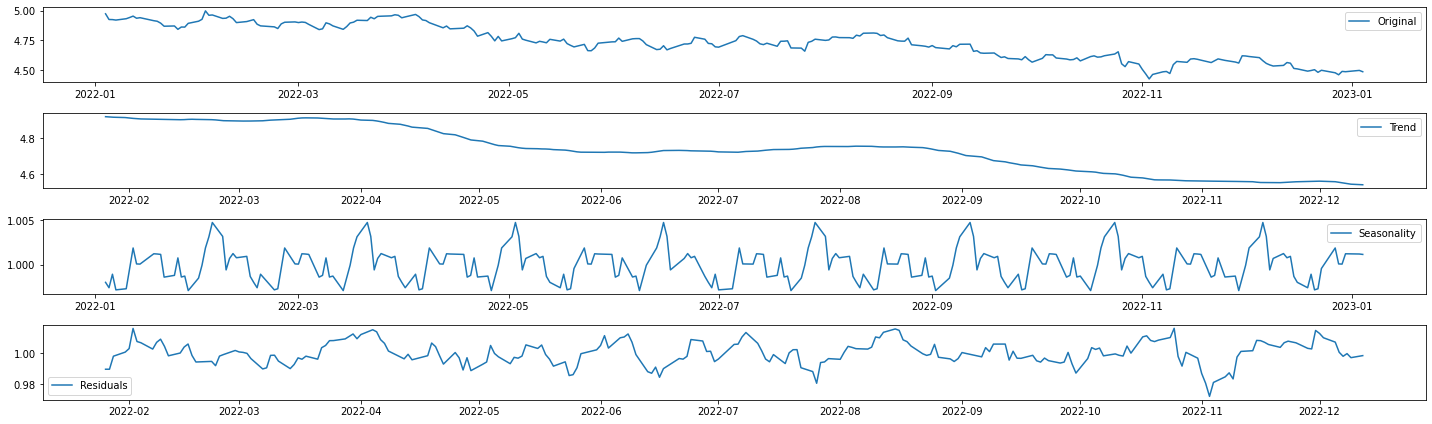

In [41]:
plt.figure(figsize=(20,6))
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

- ##### Trend와 Seasonality가 잘 제거되어서 Residual이 꽤나 랜덤해보이고 추세나 계절성이 보이지 않으므로 안정성이 있다고 볼 수 있을 것 같다.

### Residual 안정성 확인

In [42]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.408779
p-value                          0.000003
#Lags Used                       0.000000
Number of Observations Used    221.000000
Critical Value (1%)             -3.460291
Critical Value (5%)             -2.874709
Critical Value (10%)            -2.573789
dtype: float64


- #### 1) Test Statistic의 값이 Critical Value보다 낮다.
  
- #### 2) p-value가 유의수준 0.01보다 작다.

- #### 결론) 시계열은 안정적이다.

# STEP 4 : 학습, 테스트 데이터셋 생성

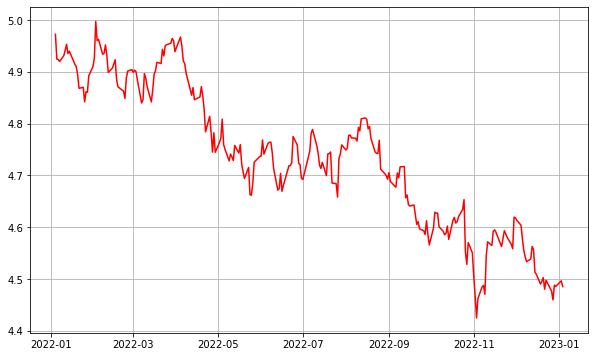

In [43]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')
plt.show()

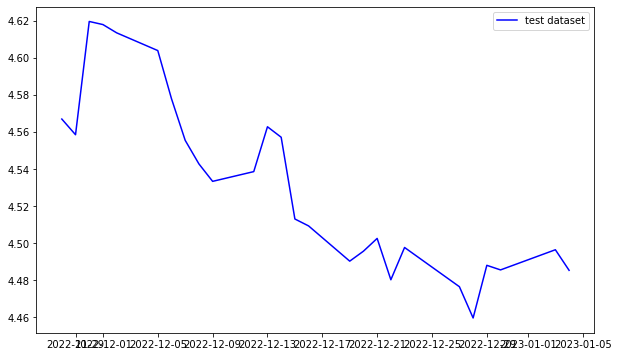

In [44]:
plt.figure(figsize=(10,6))
plt.plot(test_data, c='b', label='test dataset')
plt.legend()
plt.show()

# STEP 5 : 적정 ARIMA 모수 찾기

### ACF, PACF를 그려서 p,q 구하기

### ACF : Autocorrelation

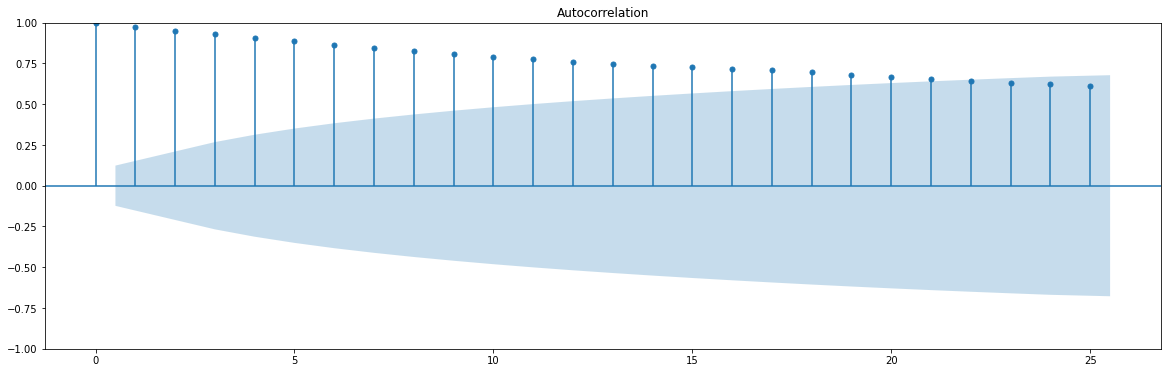

In [45]:
rcParams['figure.figsize'] = 20, 6
plot_acf(ts_log)
plt.show()

- ##### q는 acf 값이 천천히 감소하므로 0

### PACF : Partial Autocorrelation

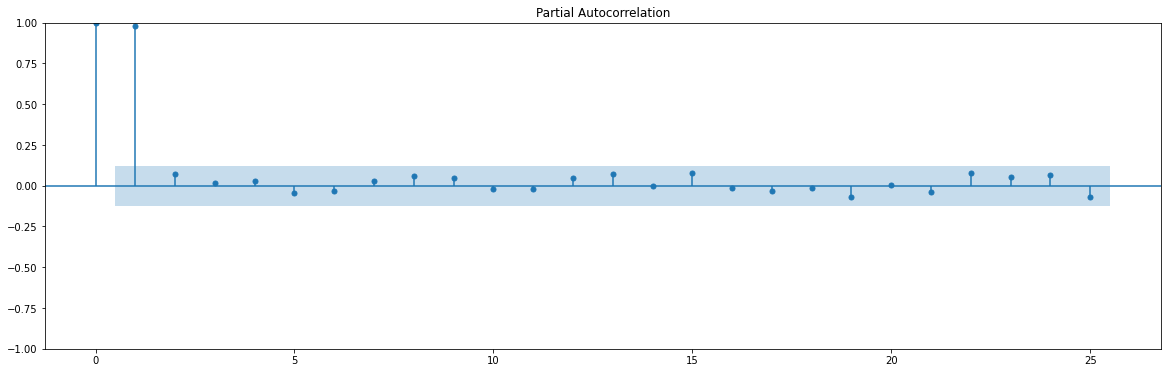

In [46]:
plot_pacf(ts_log)
plt.show()

- ##### Lag 1에서 급격히 감소하므로 p=1

### 차분 안정성 확인 -> d 구하기

##### 1차 차분 구하기

Results of Dickey-Fuller Test:
Test Statistic                -1.650107e+01
p-value                        2.148370e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64


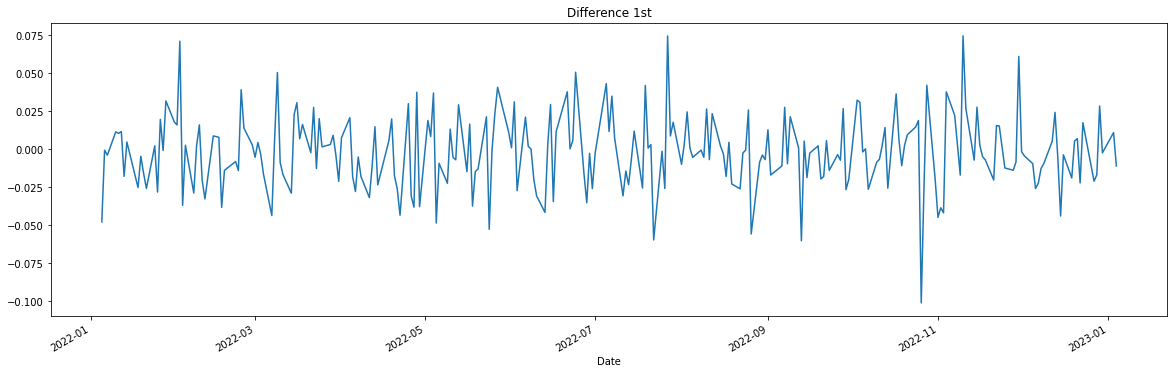

In [47]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')
augmented_dickey_fuller_test(diff_1)
plt.show()

In [48]:
print('Test Statistic', format(-1.650107e+01, '.11f'))
print('p-value', format(2.148370e-29, '.11f'))
print('Critical Value (1%)', format(-3.456781e+00, '.11f'))

Test Statistic -16.50107000000
p-value 0.00000000000
Critical Value (1%) -3.45678100000


- #### 1) Test Statistic의 값이 Critical Value보다 낮다.
  
- #### 2) p-value가 유의수준 0.01보다 작다.

- #### 결론) 시계열은 안정적이다. 2차 차분은 필요하지 않을 것 같다. d = 1

##### 혹시 필요한 경우 2차 차분 구하기

In [49]:
# diff_2 = diff_1.diff(periods=1).iloc[1:]
# diff_2.plot(title='Difference 2nd')
# augmented_dickey_fuller_test(diff_2)
# plt.show()

### ARIMA 모델 빌드와 훈련

- ##### (p, d, q)의 값으로 autoARIMA의 결과값이 궁금해서 구해봤다.

In [50]:
model = pm.AutoARIMA(seasonal = True, suppress_warnings = True, trace = True, max_D = 12)
res = model.fit(ts_log)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1147.475, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1145.876, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1145.930, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1147.892, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1143.901, Time=0.67 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.127 seconds


- ##### AutoARIMA는 (0, 1, 0)이 최선이라고 한다. 우선은 ACF, PACF, 차분을 통해서 얻은 값으로 ARIMA를 적합시켰다.

In [51]:
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit() 
print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  226
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 511.913
Date:                Thu, 05 Jan 2023   AIC                          -1019.825
Time:                        11:15:30   BIC                          -1012.993
Sample:                             0   HQIC                         -1017.068
                                - 226                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0372      0.071     -0.522      0.602      -0.177       0.103
sigma2         0.0006   4.87e-05     12.695      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.01   Jarque-

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


### 모델 테스트 및 플로팅

In [52]:
fc = fitted_m.forecast(len(test_data), alpha=0.05)
fc = np.array(fc)

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


##### Forecast : 결과가 fc에 담김

##### alpha=0.05 : 95% conf

In [53]:
fc_series = pd.Series(fc, index=test_data.index)

##### 예측 결과를 pandas series로 만듦

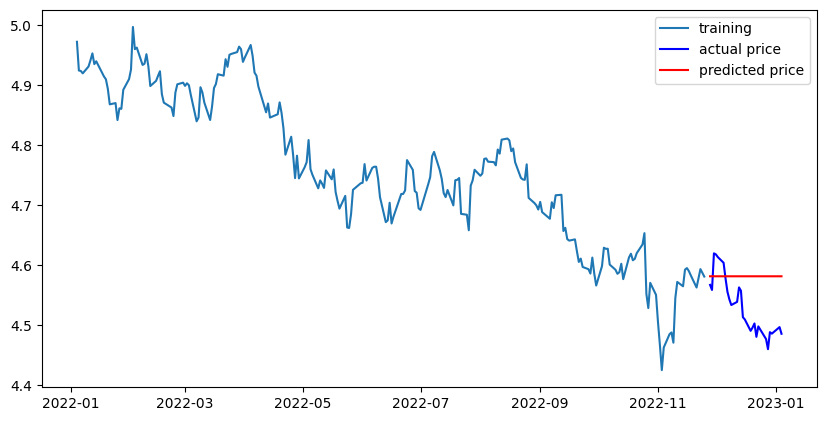

In [54]:
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

### 최종 예측 모델 정확도 측정(MAPE)

In [55]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  40.814598373281065
MAE:  5.595572349809716
RMSE:  6.388630398863364
MAPE: 6.16%


(0, 1, 0)    MAPE: 6.13%


(1, 1, 0)    MAPE: 6.16%

- ##### 오토아리마의 (0, 1, 0)이 MAPE: 6.13%으로 더 낮은 결과값을 보였다.

## 2. 마이크로소프트 - Microsoft Corporation (MSFT)

In [56]:
dataset_filepath = os.getenv('HOME') + '/aiffel/7주차/MSFT.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

In [57]:
ts.head()

Date
2022-01-04    329.010010
2022-01-05    316.380005
2022-01-06    313.880005
2022-01-07    314.040009
2022-01-10    314.269989
Name: Close, dtype: float64

In [58]:
ts = ts.interpolate(method='time')

In [59]:
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [60]:
ts_log = np.log(ts)

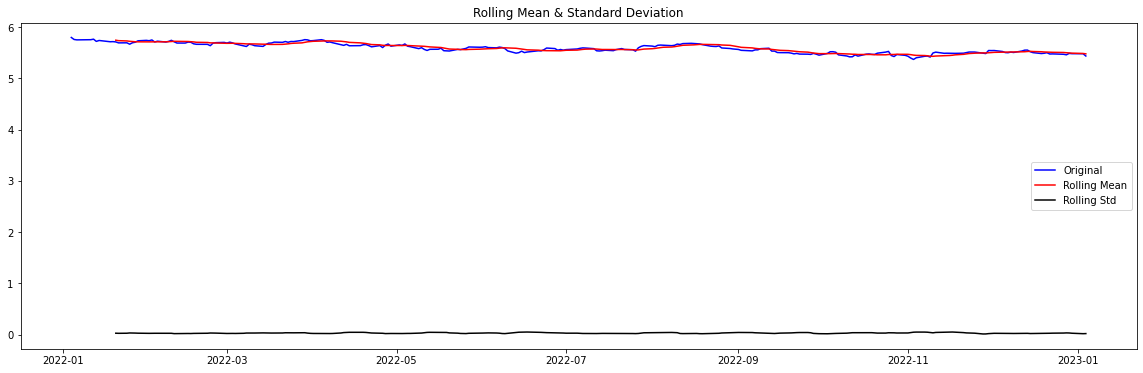

In [61]:
plot_rolling_statistics(ts_log, window=12)

- ##### 그래프만 보면 시계열이 안정성이 있어보인다.

In [62]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -2.180374
p-value                          0.213446
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


- #### 1) Test Statistic의 값이 Critical Value보다 낮아야 하는데 크다.
  
- #### 2) p-value가 유의수준 0.01보다 크다.

- #### 결론) 시계열은 안정적이지 않다.

### 시계열 분해 (Time Series Decomposition)

In [63]:
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

In [64]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

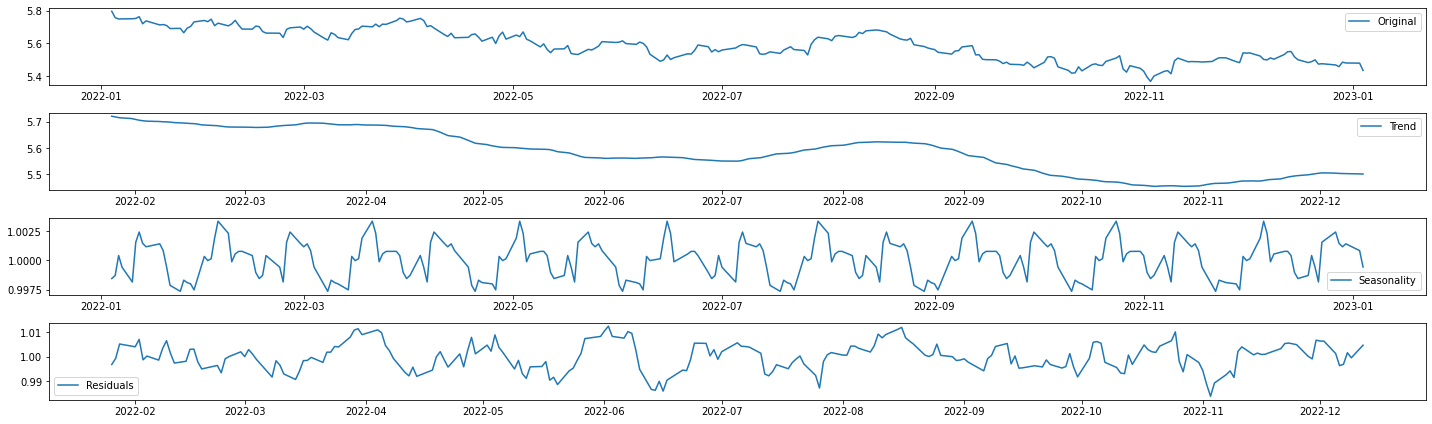

In [65]:
plt.figure(figsize=(20,6))
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

- ##### Trend와 Seasonality가 잘 제거된 것 같아보인다.

### Residual 안정성 확인

In [66]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -5.948448e+00
p-value                        2.175856e-07
#Lags Used                     9.000000e+00
Number of Observations Used    2.120000e+02
Critical Value (1%)           -3.461578e+00
Critical Value (5%)           -2.875272e+00
Critical Value (10%)          -2.574089e+00
dtype: float64


In [67]:
print('Test Statistic', format(-5.948448e+00, '.11f'))
print('p-value', format(2.175856e-07, '.11f'))
print('Critical Value (1%)', format(-3.461578e+00, '.11f'))

Test Statistic -5.94844800000
p-value 0.00000021759
Critical Value (1%) -3.46157800000


- #### 1) Test Statistic의 값이 Critical Value보다 낮다.
  
- #### 2) p-value가 유의수준 0.01보다 작다.

- #### 결론) 시계열은 안정적이다.

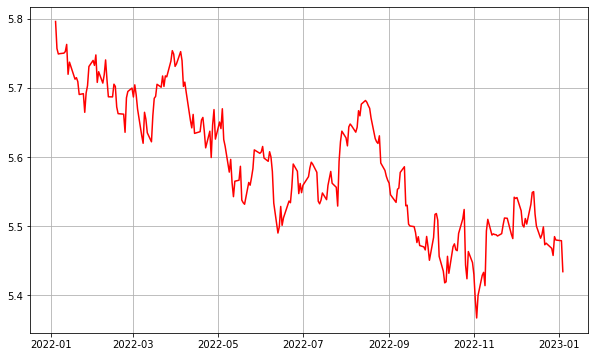

In [68]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')
plt.show()

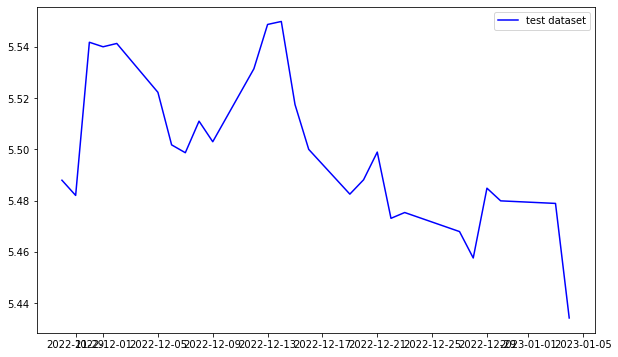

In [69]:
plt.figure(figsize=(10,6))
plt.plot(test_data, c='b', label='test dataset')
plt.legend()
plt.show()

### ACF, PACF를 그려서 p,q 구하기

### ACF : Autocorrelation

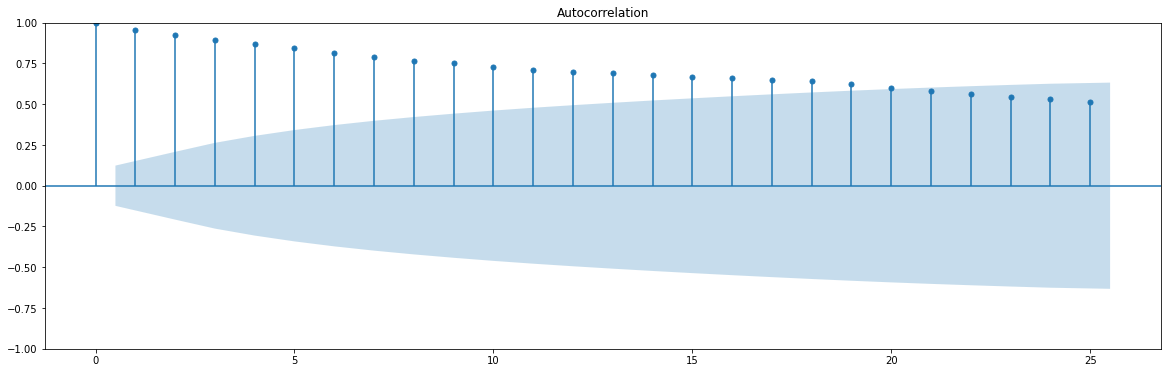

In [70]:
rcParams['figure.figsize'] = 20, 6
plot_acf(ts_log)
plt.show()

- ##### q는 acf 값이 천천히 감소하므로 0

### PACF : Partial Autocorrelation

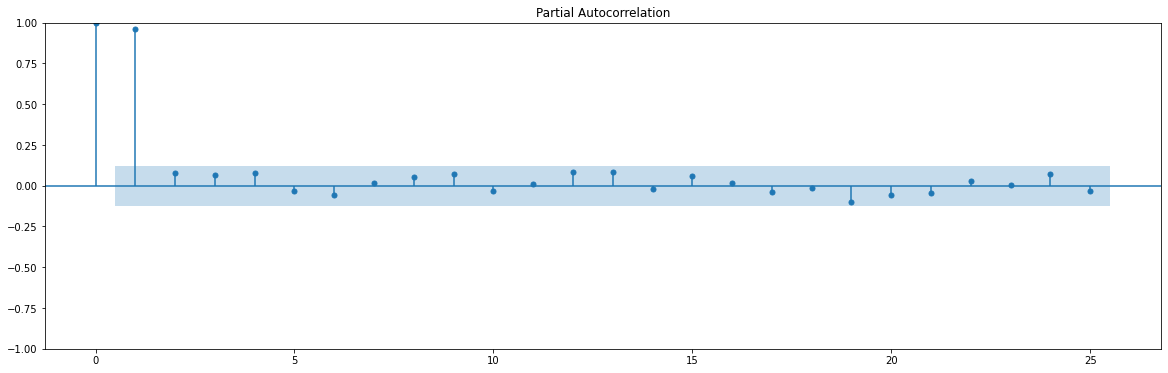

In [71]:
plot_pacf(ts_log)
plt.show()

- ##### Lag 1에서 급격히 감소하므로 p=1

### 차분 안정성 확인 -> d 구하기

##### 1차 차분 구하기

Results of Dickey-Fuller Test:
Test Statistic                -1.076181e+01
p-value                        2.509692e-19
#Lags Used                     2.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


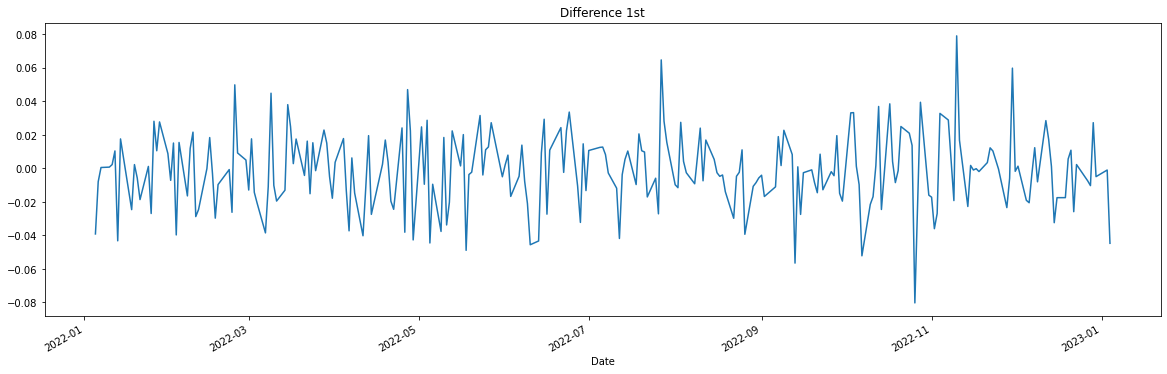

In [72]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')
augmented_dickey_fuller_test(diff_1)
plt.show()

##### 두드러지는 조건부 이분산성은 없어보인다.

In [73]:
print('Test Statistic', format(-1.076181e+01, '.11f'))
print('p-value', format(2.509692e-19, '.11f'))
print('Critical Value (1%)', format(-3.456996e+00, '.11f'))

Test Statistic -10.76181000000
p-value 0.00000000000
Critical Value (1%) -3.45699600000


- #### 1) Test Statistic의 값이 Critical Value보다 낮다.
  
- #### 2) p-value가 유의수준 0.01보다 작다.

- #### 결론) 시계열은 안정적이다. 2차 차분은 필요하지 않을 것 같다. d = 1

##### 혹시 필요한 경우 2차 차분 구하기

In [74]:
# diff_2 = diff_1.diff(periods=1).iloc[1:]
# diff_2.plot(title='Difference 2nd')
# augmented_dickey_fuller_test(diff_2)
# plt.show()

### ARIMA 모델 빌드와 훈련

- ##### (p, d, q)의 값으로 autoARIMA의 결과값이 궁금해서 구해봤다.

In [75]:
model = pm.AutoARIMA(seasonal = True, suppress_warnings = True, trace = True, max_D = 12)
res = model.fit(ts_log)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1187.748, Time=0.98 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1191.309, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1189.460, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1189.495, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1192.269, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1187.476, Time=0.43 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.815 seconds


- ##### AutoARIMA는 (0, 1, 0)이 최선이라고 한다. 우선은 ACF, PACF, 차분을 통해서 얻은 값으로 ARIMA를 적합시켰다.

In [76]:
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit() 
print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  226
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 534.015
Date:                Thu, 05 Jan 2023   AIC                          -1064.030
Time:                        11:15:35   BIC                          -1057.198
Sample:                             0   HQIC                         -1061.273
                                - 226                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0267      0.070     -0.380      0.704      -0.165       0.111
sigma2         0.0005   4.33e-05     11.728      0.000       0.000       0.001
Ljung-Box (L1) (Q):                   0.01   Jarque-

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

### 모델 테스트 및 플로팅

In [77]:
fc = fitted_m.forecast(len(test_data), alpha=0.05)
fc = np.array(fc)

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


##### Forecast : 결과가 fc에 담김

##### alpha=0.05 : 95% conf

In [78]:
fc_series = pd.Series(fc, index=test_data.index)

##### 예측 결과를 pandas series로 만듦

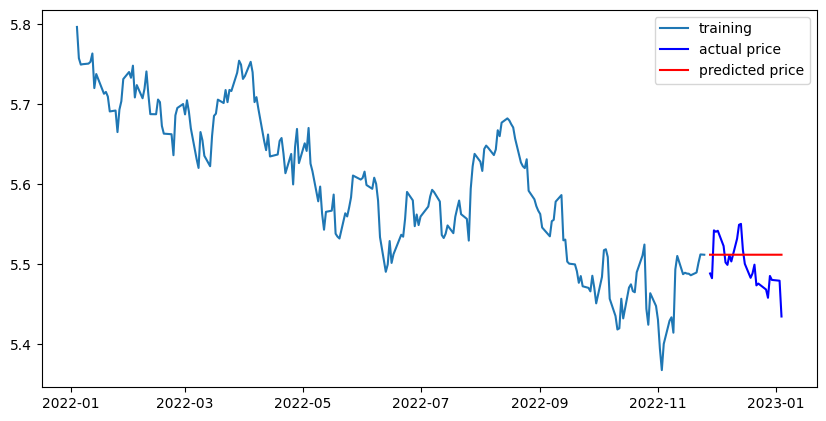

In [79]:
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

### 최종 예측 모델 정확도 측정(MAPE)

In [80]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  58.93771379423309
MAE:  6.6132127089879145
RMSE:  7.677090190575664
MAPE: 2.72%


(1, 1, 0)    MAPE: 2.72%

(0, 1, 0)    MAPE: 2.72%

- ##### 그래프만 봐서는 잘 맞추지 못한 듯 하나 MAPE은 둘 다 2.72%로 같은 성능을 보였다.

## 3. 부킹홀딩스 - Booking Holdings Inc. (BKNG)

In [81]:
dataset_filepath = os.getenv('HOME') + '/aiffel/7주차/BKNG.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

In [82]:
ts.head()

Date
2022-01-04    2464.929932
2022-01-05    2413.300049
2022-01-06    2429.969971
2022-01-07    2434.580078
2022-01-10    2426.399902
Name: Close, dtype: float64

In [83]:
ts = ts.interpolate(method='time')

In [84]:
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [85]:
ts_log = np.log(ts)

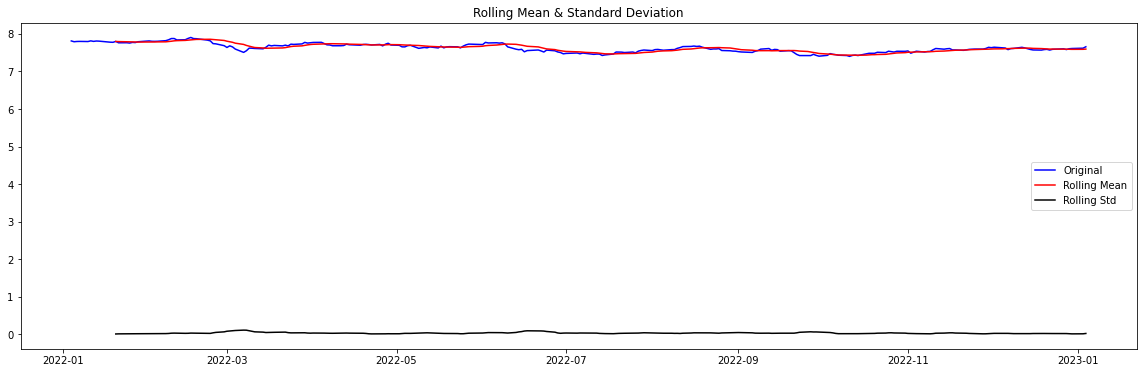

In [86]:
plot_rolling_statistics(ts_log, window=12)

- ##### 그래프만 보면 시계열이 안정성이 있어보인다.

In [87]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -2.207477
p-value                          0.203543
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


- #### 1) Test Statistic의 값이 Critical Value보다 낮아야 하는데 크다.
  
- #### 2) p-value가 유의수준 0.01보다 크다.

- #### 결론) 시계열은 안정적이지 않다.

### 시계열 분해 (Time Series Decomposition)

In [88]:
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

In [89]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

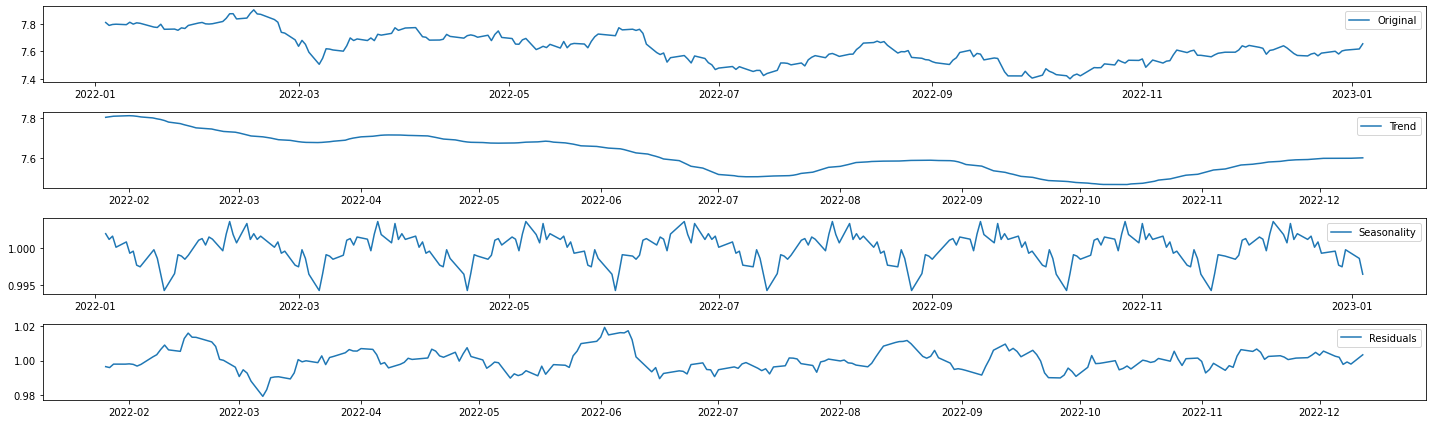

In [90]:
plt.figure(figsize=(20,6))
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

- ##### Trend와 Seasonality가 잘 제거된 것 같아보인다.

### Residual 안정성 확인

In [91]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.600343
p-value                          0.000001
#Lags Used                       5.000000
Number of Observations Used    216.000000
Critical Value (1%)             -3.460992
Critical Value (5%)             -2.875016
Critical Value (10%)            -2.573952
dtype: float64


- #### 1) Test Statistic의 값이 Critical Value보다 낮다.
  
- #### 2) p-value가 유의수준 0.01보다 작다.

- #### 결론) 시계열은 안정적이다.

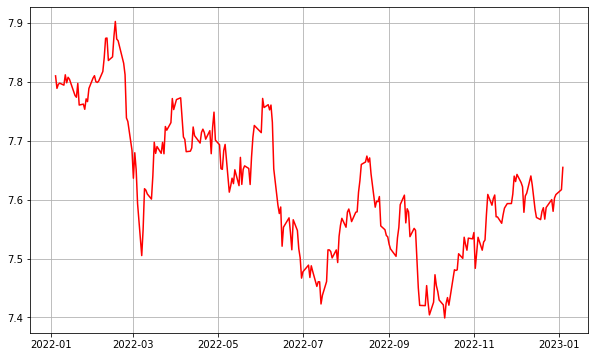

In [92]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')
plt.show()

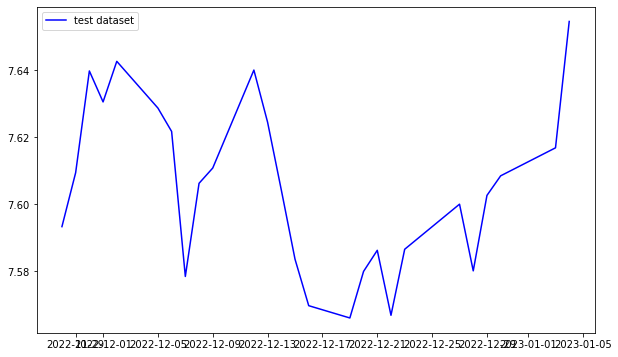

In [93]:
plt.figure(figsize=(10,6))
plt.plot(test_data, c='b', label='test dataset')
plt.legend()
plt.show()

### ACF, PACF를 그려서 p,q 구하기

### ACF : Autocorrelation

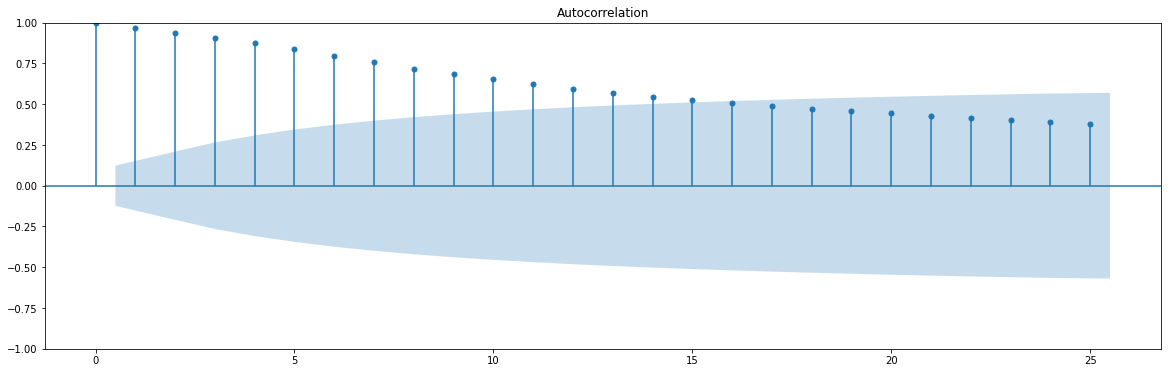

In [94]:
rcParams['figure.figsize'] = 20, 6
plot_acf(ts_log)
plt.show()

- ##### q는 acf 값이 천천히 감소하므로 0

### PACF : Partial Autocorrelation

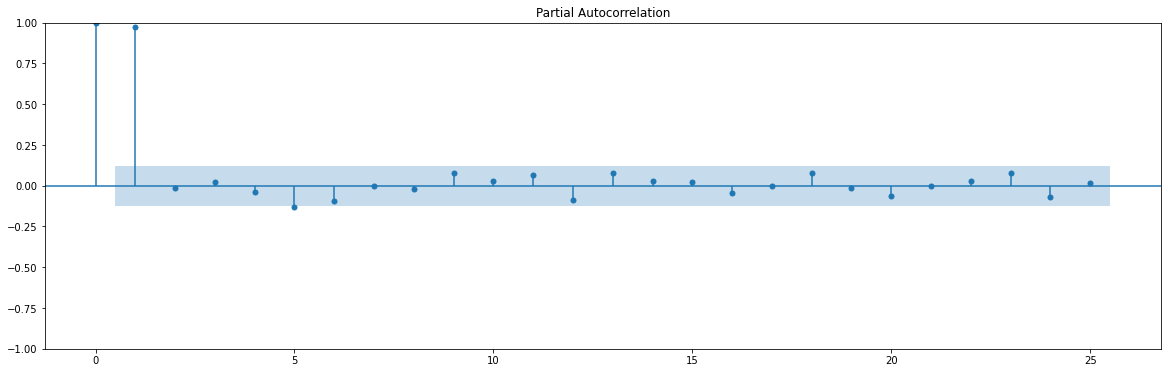

In [95]:
plot_pacf(ts_log)
plt.show()

- ##### Lag 1에서 급격히 감소하므로 p=1

### 차분 안정성 확인 -> d 구하기

##### 1차 차분 구하기

Results of Dickey-Fuller Test:
Test Statistic                -1.537689e+01
p-value                        3.448780e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64


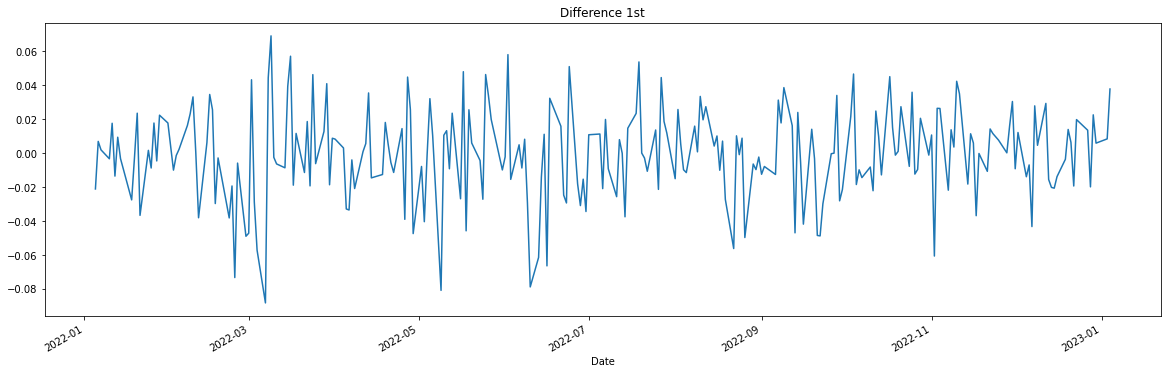

In [96]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')
augmented_dickey_fuller_test(diff_1)
plt.show()

In [97]:
print('Test Statistic', format(-1.537689e+01, '.11f'))
print('p-value', format(3.448780e-28, '.11f'))
print('Critical Value (1%)', format(-3.456781e+00, '.11f'))

Test Statistic -15.37689000000
p-value 0.00000000000
Critical Value (1%) -3.45678100000


- #### 1) Test Statistic의 값이 Critical Value보다 낮다.
  
- #### 2) p-value가 유의수준 0.01보다 작다.

- #### 결론) 시계열은 안정적이다. 2차 차분은 필요하지 않을 것 같다. d = 1

##### 혹시 필요한 경우 2차 차분 구하기

In [98]:
# diff_2 = diff_1.diff(periods=1).iloc[1:]
# diff_2.plot(title='Difference 2nd')
# augmented_dickey_fuller_test(diff_2)
# plt.show()

### ARIMA 모델 빌드와 훈련

- ##### (p, d, q)의 값으로 autoARIMA의 결과값이 궁금해서 구해봤다.

In [99]:
model = pm.AutoARIMA(seasonal = True, suppress_warnings = True, trace = True, max_D = 12)
res = model.fit(ts_log)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1092.583, Time=1.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1097.845, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1095.954, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1095.965, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1099.713, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1094.141, Time=0.14 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.607 seconds


- ##### AutoARIMA는 (0, 1, 0)이 최선이라고 한다. 우선은 ACF, PACF, 차분을 통해서 얻은 값으로 ARIMA를 적합시켰다.

In [100]:
model = ARIMA(train_data, order=(0, 1, 0))  
fitted_m = model.fit() 
print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  226
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 487.903
Date:                Thu, 05 Jan 2023   AIC                           -973.806
Time:                        11:15:39   BIC                           -970.390
Sample:                             0   HQIC                          -972.427
                                - 226                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0008   6.59e-05     11.610      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                 6.13
Prob(Q):                              0.72   Pr

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


### 모델 테스트 및 플로팅

In [101]:
fc = fitted_m.forecast(len(test_data), alpha=0.05)
fc = np.array(fc)

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


##### Forecast : 결과가 fc에 담김

##### alpha=0.05 : 95% conf

In [102]:
fc_series = pd.Series(fc, index=test_data.index)

##### 예측 결과를 pandas series로 만듦

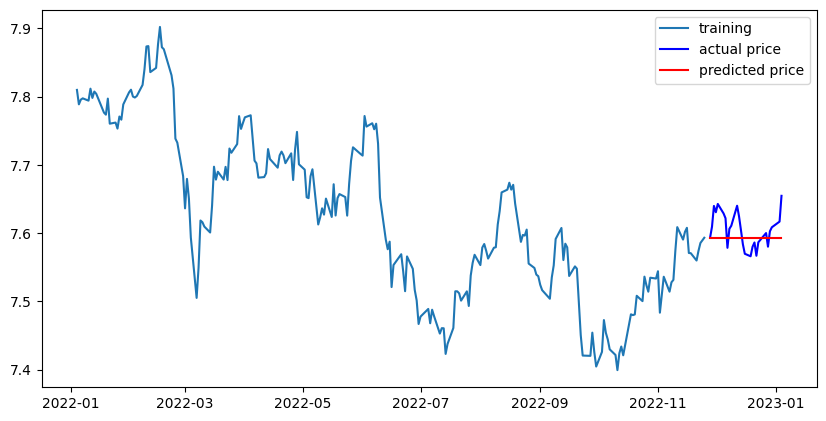

In [103]:
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

### 최종 예측 모델 정확도 측정(MAPE)

In [104]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  3078.2996186638984
MAE:  45.76884100000007
RMSE:  55.48242621464835
MAPE: 2.25%


(1, 1, 0)    MAPE: 2.25%

(0, 1, 0)    MAPE: 2.25%

- ##### 둘 다 2.25%로 같은 성능을 보였다.

--------

# 회고

- ### 어려웠던 점 / 해결을 위해 시도한 방법 / 문제해결에 성공한 이유 또는 실패한 이유

##### ACF와 PACF를 통해 p, q 값을 구하는 방식을 이해하지 못해서 힘들었다. 그래서 시계열 데이터를 다루기 시작한 노드를 처음부터 모두 다 다시 봤다. 복습을 하다보니 p, q 값을 어떻게 찾아내는 지 알 수 있었다.

- ### 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점

##### ACF와 PACF에서 어떤 값을 유의미하게 봐야할 지 알게 됐다. 그런데 그렇게 구해낸 p, q의 값으로 그린 예측 그래프가 생각보다 예측을 잘 못한 것처럼 보였다. 그럼에도 불구하고 MAPE가 2%가 나오는 부분이 이상하다.

##### 경고 문구를 제거하는 모듈을 가져왔는데도 불구하고 ARIMA 모델은 경고 문구가 사라지지 않는 게 이상하다.

- ### 자기 다짐 / 프로젝트를 진행하면서 느낀점

##### 복습을 잘 해뒀으면 시계열 데이터에 대한 노드를 처음부터 보지 않아도 됐을 것이다. 복습하는 습관을 들여야겠다. 그리고 주가는 예측이 어렵다는 것을 알아냈다. 만약 내가 주가를 알고 싶다면 석유가격을 예측할 때 인공위성으로 석유 저장소의 원유 저장통을 얼마나 쌓았는지에 따라 달라지는 그림자를 이용하여 예측하는 모델이 있듯이, 다른 요소도 평가에 고려해야 더 좋은 예측 결과가 나올 것 같다.